# Fake data from Bayesian networks


In [1]:
import numpy as np
import pandas as pd
from fake_data_for_learning import BayesianNodeRV as BNRV
from fake_data_for_learning import FakeDataBayesianNetwork as FDBN
from fake_data_for_learning import SampleValue
import sklearn
%matplotlib inline

## Example
$X = (X0, X1)$, where $X$ admits the graph

G: X0 -> X1

First define random node variables for $X0$ and $X1 | X0$, where $X0$ can be sampled with no additional arguments, while $X1 | X0$ must be provided a value for $X0$ to generate a random sample.

### Sampling from the nodes

In [2]:
pt_X0 = np.array([0.8, 0.2])
rv0 = BNRV('X0', pt_X0)
rv0.rvs()

0

In [3]:
pt_X1cX0 = np.array([
        [0.2, 0.8],
        [0.7, 0.3],
    ])

rv1c0 = BNRV('X1', pt_X1cX0, parent_names=['X0'])
parent_values={'X0': SampleValue(1)}
# Get probability table when X0=1
rv1c0.get_pt(parent_values)

array([0.7, 0.3])

In [4]:
rv1c0.rvs(size=10, parent_values={'X0': SampleValue(1)})

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Sampling from the graph

To generate a random sample for $X$, we define the adjacency graph of $G$ and use this to first sample from the Eve-nodes (no parents), and then Eve's immediate descendents, and so on. 

In [5]:
bn = FDBN(rv0, rv1c0)

/Users/pauldev/.virtualenvs/fake-data/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/pauldev/.virtualenvs/fake-data/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


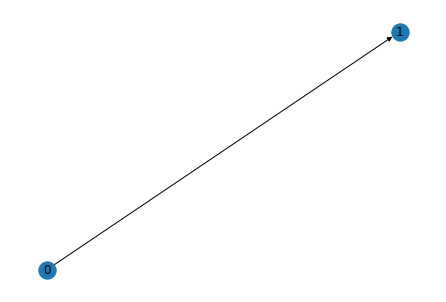

In [6]:
# Visualize the graph
bn.draw_graph()

In [7]:
# Sample
bn.rvs(size=5)

,X0,X1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


## Example

$X = (X0, X1, X2)$, where $X$ admits the graph

G: X0 -> X2 <- X1

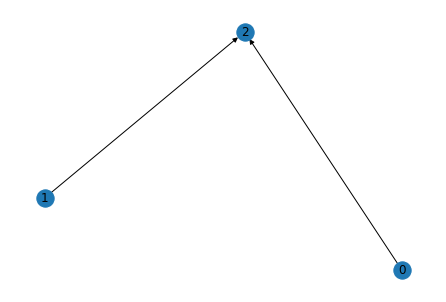

In [8]:
# X1
pt_X1 = np.array([0.5, 0.3, 0.2])
rv1 = BNRV('X1', pt_X1)

# X2 | X0, X1
pt_X2cX0X1 = np.array([
    [
        [0., 1.0],
        [0.2, 0.8],
        [0.1, 0.9]
    ],
    [
        [0.5, 0.5],
        [0.3, 0.7],
        [0.9, 0.1]
    ],

])

rv2c01 = BNRV('X2', pt_X2cX0X1, parent_names=['X0', 'X1'])

bn2c01 = FDBN(rv0, rv1, rv2c01)
bn2c01.draw_graph()

In [9]:
# Sample
bn2c01.rvs(size=5)

,X0,X1,X2
0,0,0,1
1,0,1,1
2,0,0,1
3,1,1,1
4,0,1,1


## Bayesian network with non-default (non-integer) outcome values

In [10]:
# With non-default valued outocomes
rv0_nondef = BNRV('X0', pt_X0, values=['a', 'b'])
rv1c0_nondef = BNRV('X1', pt_X1cX0, parent_names=['X0'], values=['male', 'female'])
bn_nondef = FDBN(rv0_nondef, rv1c0_nondef)
bn_nondef.rvs(size=10)

,X0,X1
0,a,male
1,a,female
2,b,male
3,b,male
4,a,male
5,b,male
6,a,female
7,a,female
8,a,female
9,a,female
